In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.spatial.distance import pdist, squareform, euclidean
from sklearn.metrics.pairwise import cosine_similarity
from fastdtw import fastdtw

## Load, Transform, and Explore the Dataset

In [2]:
DATA_FILE = 'time_series_covid19_confirmed_global.csv'
def load_data():
    """
    Load data from a source and perform data preprocessing.

    Returns:
    DataFrame: Processed DataFrame with top 5 countries based on cumulative cases.
    """

    # =============================================================================
    # Step 1: Data Loading
    # =============================================================================
    
    # Load data from source
    df = pd.read_csv(DATA_FILE)

    # =============================================================================
    # Step 2: Data Preprocessing
    # =============================================================================

    # Drop unnecessary columns
    df.drop(['Province/State', 'Lat', 'Long'], axis=1, inplace=True)

    # Group by 'Country/Region' column and aggregate corresponding values
    df_grouped = df.groupby('Country/Region').agg('sum').reset_index()

    # =============================================================================
    # Step 3: Reshaping DataFrame
    # =============================================================================

    # Transpose DataFrame
    df_transposed = df_grouped.transpose()
    df_transposed.reset_index(inplace=True)

    # Reset index and set the first row as column names
    df_transposed.columns = df_transposed.iloc[0]
    df_transposed.drop(df_transposed.index[0], inplace=True)

    # Rename columns
    df_transposed.rename(columns={'Country/Region': 'Date'}, inplace=True)

    # Reset index to DateTimeIndex
    df_transposed['Date'] = pd.to_datetime(df_transposed['Date'])
    df_transposed.set_index('Date', inplace=True)

    # =============================================================================
    # Step 4: Determining Top 5 Countries
    # =============================================================================

    # Calculate the sum of each column
    column_sums = df_transposed.sum()

    # Sort the sums in descending order and select the top 5 column names
    top_5_columns = column_sums.sort_values(ascending=False).head(5).index

    # Filter the DataFrame to keep only the top 5 columns
    df_top_5 = df_transposed[top_5_columns]

    return df_top_5


In [3]:
df_top_5 = load_data()
df_top_5.head()

,US,India,Brazil,France,Germany
Date,,,,,
2020-01-22,1,0,0,0,0
2020-01-23,1,0,0,0,0
2020-01-24,2,0,0,2,0
2020-01-25,2,0,0,3,0
2020-01-26,5,0,0,3,0


In [4]:
import matplotlib.pyplot as plt

def plot_daily_cases(df_top_5):
    """
    Plot daily cases for each country in the top 5 for most cumulative cases.

    Args:
    df_top_5 (DataFrame): DataFrame containing data for top 5 countries based on cumulative cases.
    """

    # Plot each country's daily cases
    for country in df_top_5.columns:
        plt.plot(df_top_5.index, df_top_5[country], label=country)

    # Add labels and title
    plt.xlabel('Date')
    plt.ylabel('Daily Cases')
    plt.title('Daily Cases for Top 5 Countries with Most Cumulative Cases')

    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45)

    # Add legend
    plt.legend()

    # Show plot
    plt.show()

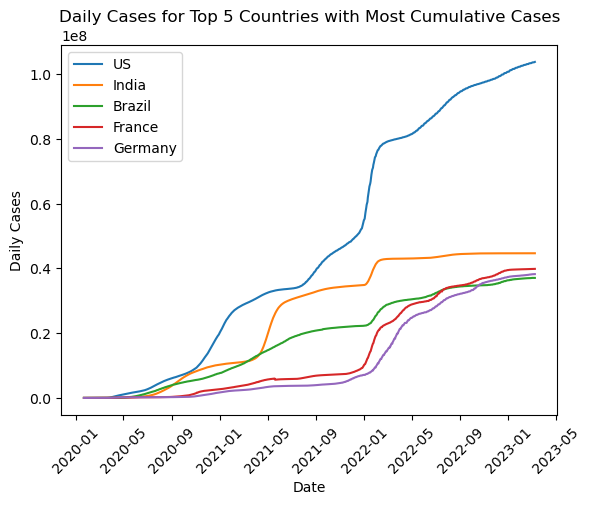

In [5]:
# Plot daily cases for top 5 countries
plot_daily_cases(df_top_5)

## Extract seasonal Components

In [6]:
def sea_decomp(input_df):
    """
    Decompose the time series data in the input DataFrame into seasonal components.

    Args:
    input_df (DataFrame): Input DataFrame with time series data(top 5).

    Returns:
    DataFrame: DataFrame containing the seasonal components of the input time series data.
    """

    # Initialize an empty DataFrame to store the seasonal components
    output_df = pd.DataFrame(index=input_df.index)

    # Iterate over each column in the input DataFrame
    for column in input_df.columns:
        # Perform seasonal decomposition using statsmodels seasonal_decompose function
        result = seasonal_decompose(input_df[column], model='additive', period=7)

        # Extract the seasonal component from the decomposition results
        seasonal_component = result.seasonal

        # Fill any NaN values with the mean of the seasonal component
        seasonal_component.fillna(seasonal_component.mean(), inplace=True)

        # Add the seasonal component to the output DataFrame
        output_df[column] = seasonal_component

    return output_df


In [7]:
def plot_seasonal_components(sea_df):
    fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 10))
    axes = axes.flatten()  # Flatten the 2D array of axes
    
    # Plot all seasonal components in the first subplot
    for column in sea_df.columns:
        sea_df[column].plot(ax=axes[0], label=column)
    axes[0].set_title('All Seasonal Components')
    axes[0].legend()
    
    # Plot each seasonal component individually
    for i, column in enumerate(sea_df.columns, start=1):
        sea_df[column].plot(ax=axes[i], label=column, color='blue')
        axes[i].set_title(f'Seasonal Component for {column}')
        axes[i].legend()
        
    plt.tight_layout()
    plt.show()

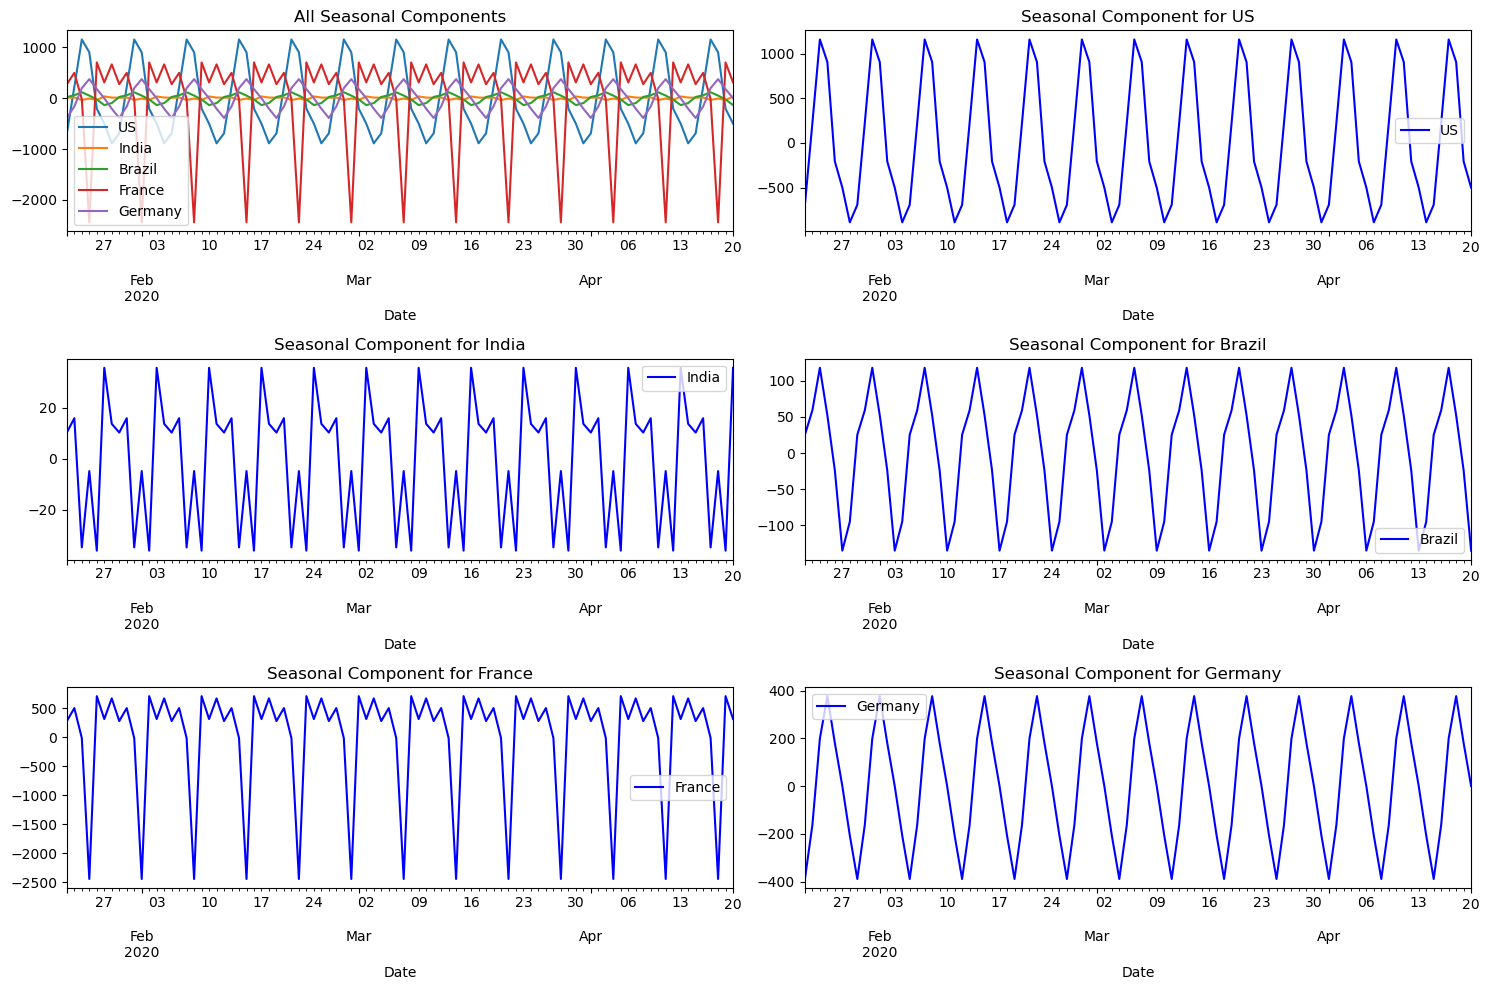

In [8]:
# plot first 90 days sarting from '1/22/2020'
sea_df = sea_decomp(sea_decomp(df_top_5.iloc[0:90]))
plot_seasonal_components(sea_df)

## Time Series Similarities
---

### Euclidean Distance

In [9]:
def calc_euclidean_dist(seasonal_components):
    """
    Calculate pairwise Euclidean distances between time series data for the top 5 countries.

    Args:
    seasonal_components (DataFrame): DataFrame containing seasonal components of time series data.

    Returns:
    DataFrame: Symmetric matrix of all pairwise Euclidean distances.
    """

    # Calculate pairwise Euclidean distances using pdist
    pairwise_distances = pdist(seasonal_components.transpose(), metric='euclidean')

    # Convert pairwise distances to a symmetric matrix
    symmetric_matrix = squareform(pairwise_distances)

    # Create a DataFrame from the symmetric matrix with country names as index and column names
    euclidean_dist_df = pd.DataFrame(symmetric_matrix, index=seasonal_components.columns.tolist(), columns=seasonal_components.columns.tolist())

    return euclidean_dist_df


In [10]:
calc_euclidean_dist(sea_df)

,US,India,Brazil,France,Germany
US,0.000000,7076.119375,6343.388807,15010.044347,5428.947122
India,7076.119375,0.000000,947.271580,9725.650924,2507.266240
Brazil,6343.388807,947.271580,0.000000,10054.050928,2289.701404
France,15010.044347,9725.650924,10054.050928,0.000000,11378.679635
Germany,5428.947122,2507.266240,2289.701404,11378.679635,0.000000


### Cosine Similarity

In [11]:
def calc_cos_sim(seasonal_components):
    """
    Calculate pairwise cosine similarities between time series data for the top 5 countries.

    Args:
    seasonal_components (DataFrame): DataFrame containing seasonal components of time series data.

    Returns:
    DataFrame: Symmetric matrix of all pairwise cosine similarities.
    """
    
    # Calculate pairwise cosine similarities using cosine_similarity
    pairwise_cos_sim = cosine_similarity(seasonal_components.transpose())

    # Create a DataFrame from the pairwise cosine similarities with country names as index and column names
    cos_sim_df = pd.DataFrame(pairwise_cos_sim, index=seasonal_components.columns.tolist(), columns=seasonal_components.columns.tolist())

    return cos_sim_df


In [12]:
calc_cos_sim(sea_df)

,US,India,Brazil,France,Germany
US,1.000000,-0.550405,0.782398,-0.606881,0.740497
India,-0.550405,1.000000,-0.576218,0.097151,-0.565395
Brazil,0.782398,-0.576218,1.000000,-0.355725,0.260875
France,-0.606881,0.097151,-0.355725,1.000000,-0.626882
Germany,0.740497,-0.565395,0.260875,-0.626882,1.000000


## Dynamic Time Warping (DTW) Cost
---

In [13]:
def calc_pairwise_dtw_cost(x, y, rep_matrix=False, take_root=True):
    """
    Calculate the DTW cost for two time series x and y.

    Args:
    x (array-like): First time series.
    y (array-like): Second time series.
    rep_matrix (bool): If True, return a matrix of DTW costs.
                                 If False, return the total DTW cost.
                                 Default is False.
    take_root (bool): If True, return the square root of the total DTW cost.
                                Only applicable when rep_matrix=False.
                                Default is False.

    Returns:
    float or numpy.ndarray: DTW cost or matrix of DTW costs.
    """
    
    # Compute the length of input time series
    n = len(x)
    m = len(y)
    
    # Initialize the cumulative cost matrix
    cum_cost = np.zeros((n, m))
    
    # Compute the Euclidean distance between each pair of points
    dist_matrix = np.zeros((n, m))
    for i in range(n):
        for j in range(m):
            dist_matrix[i, j] = (x[i] - y[j]) ** 2
    
    # Initialize the cumulative cost matrix
    cum_cost[0, 0] = dist_matrix[0, 0]
    for i in range(1, n):
        cum_cost[i, 0] = cum_cost[i - 1, 0] + dist_matrix[i, 0]
    for j in range(1, m):
        cum_cost[0, j] = cum_cost[0, j - 1] + dist_matrix[0, j]
    
    # Populate the cumulative cost matrix
    for i in range(1, n):
        for j in range(1, m):
            cum_cost[i, j] = dist_matrix[i, j] + min(cum_cost[i - 1, j], cum_cost[i, j - 1], cum_cost[i - 1, j - 1])
    
    # Return the appropriate output based on function arguments
    if rep_matrix:
        return cum_cost
    else:
        dtw_cost = cum_cost[n - 1, m - 1]
        if take_root:
            dtw_cost = np.sqrt(dtw_cost)
        return dtw_cost


In [14]:
def calc_dtw_cost(seasonal_components):
    """
    Calculate pairwise DTW costs between time series data for the top 5 countries.

    Args:
    seasonal_components (DataFrame): DataFrame containing seasonal components of time series data.

    Returns:
    DataFrame: Symmetric matrix of all pairwise DTW costs.
    """

    # Assign column names
    countries = seasonal_components.columns.tolist()

    # Initialize DataFrame to store pairwise DTW costs
    dtw_cost_df = pd.DataFrame(index=countries, columns=countries)

    # Compute pairwise DTW costs
    for i, country1 in enumerate(countries):
        for j, country2 in enumerate(countries):
            if i <= j:
                dtw_cost = calc_pairwise_dtw_cost(seasonal_components[country1], seasonal_components[country2], rep_matrix=False, take_root=True)
                dtw_cost_df.loc[country1, country2] = dtw_cost
                dtw_cost_df.loc[country2, country1] = dtw_cost

    return dtw_cost_df


In [15]:
# Calculate pairwise DTW costs for extracted seasonal components
seasonal_dtw_costs  = calc_dtw_cost(sea_df)
seasonal_dtw_costs

,US,India,Brazil,France,Germany
US,0.0,6807.647472,6126.687823,8301.721425,4534.313053
India,6807.647472,0.0,591.263826,9519.072434,2096.474897
Brazil,6126.687823,591.263826,0.0,9215.780861,1639.221395
France,8301.721425,9519.072434,9215.780861,0.0,8283.471703
Germany,4534.313053,2096.474897,1639.221395,8283.471703,0.0
